# Simulated annealing - Continuous Optimization

A. Cabri & F. Masulli DIBRIS - UNIGE

modified from https://github.com/Naereen/notebooks/blob/master/Simulated_annealing_in_Python.ipynb by [Lilian Besson](https://GitHub.com/Naereen)

This small notebook implements, in [Python 3](https://docs.python.org/3/), the [simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing) algorithm for numerical optimization.

## References
- The Wikipedia page: [simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing).
- It was implemented in `scipy.optimize` before version 0.14: [`scipy.optimize.anneal`](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.optimize.anneal.html).
- [This blog post](http://apmonitor.com/me575/index.php/Main/SimulatedAnnealing).
- These Stack Overflow questions: [15853513](https://stackoverflow.com/questions/15853513/) and [19757551](https://stackoverflow.com/questions/19757551/).

## See also
- For a real-world use of simulated annealing, this Python module seems useful: [perrygeo/simanneal on GitHub](https://github.com/perrygeo/simanneal).

## About
- *Date:* 20/07/2017.
- *Author:* [Lilian Besson](https://GitHub.com/Naereen), (C) 2017.
- *Licence:* [MIT Licence](http://lbesson.mit-license.org).

----

> This notebook should be compatible with both Python versions, [2](https://docs.python.org/2/) and [3](https://docs.python.org/3/).

# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Simulated-annealing-in-Python" data-toc-modified-id="Simulated-annealing-in-Python-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Simulated annealing in Python</a></div><div class="lev2 toc-item"><a href="#References" data-toc-modified-id="References-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>References</a></div><div class="lev2 toc-item"><a href="#See-also" data-toc-modified-id="See-also-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>See also</a></div><div class="lev2 toc-item"><a href="#About" data-toc-modified-id="About-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>About</a></div><div class="lev2 toc-item"><a href="#Algorithm" data-toc-modified-id="Algorithm-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Algorithm</a></div><div class="lev2 toc-item"><a href="#Basic-but-generic-Python-code" data-toc-modified-id="Basic-but-generic-Python-code-15"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Basic but generic Python code</a></div><div class="lev2 toc-item"><a href="#Basic-example" data-toc-modified-id="Basic-example-16"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Basic example</a></div><div class="lev2 toc-item"><a href="#Visualizing-the-steps" data-toc-modified-id="Visualizing-the-steps-17"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Visualizing the steps</a></div><div class="lev2 toc-item"><a href="#More-visualizations" data-toc-modified-id="More-visualizations-18"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>More visualizations</a></div>

In [1]:
from __future__ import print_function, division  # Python 2 compatibility if needed

In [2]:
import numpy as np
import numpy.random as rn
import matplotlib.pyplot as plt  # to plot
import matplotlib as mpl

from scipy import optimize       # to compare

import seaborn as sns  #seaborn: statistical data visualization
sns.set(context="talk", style="darkgrid", palette="hls", font="sans-serif", font_scale=1.05)

FIGSIZE = (19, 8)  #: Figure size, in inches!
mpl.rcParams['figure.figsize'] = FIGSIZE

----

## Algorithm

The following pseudocode presents the simulated annealing heuristic.

- It starts from a state $s_0$ and continues to either a maximum of $k_{\max}$ steps or until a state with an energy of $e_{\min}$ or less is found.
- In the process, the call $\mathrm{neighbour}(s)$ should generate a randomly chosen neighbour of a given state $s$.
- The annealing schedule is defined by the call $\mathrm{temperature}(r)$, which should yield the temperature to use, given the fraction $r$ of the time budget that has been expended so far.

> **Simulated Annealing**:
> 
> - Let $s$ = $s_0$
> - For $k = 0$ through $k_{\max}$ (exclusive):
>    + $T := \mathrm{temperature}(k ∕ k_{\max})$
>    + Pick a random neighbour, $s_{\mathrm{new}} := \mathrm{neighbour}(s)$
>    + If $P(E(s), E(s_{\mathrm{new}}), T) \geq \mathrm{random}(0, 1)$:
>       * $s := s_{\mathrm{new}}$
> - Output: the final state $s$

----

## Basic but generic Python code

Let us start with a very generic implementation:

In [3]:
def annealing(random_start,
              cost_function,
              random_neighbour,
              acceptance,
              temperature,
              maxsteps=1000,
              debug=True):
    """ Optimize the black-box function 'cost_function' with the simulated annealing algorithm."""
    state = random_start()+1
    cost = cost_function(state)
    states, costs = [state], [cost]
    for step in range(maxsteps):  # range(maxsteps) Creates sequence of numbers from 0 to maxsteps
        fraction = step / float(maxsteps)
        T = temperature(fraction)
        #print ('>>>', step, maxsteps,fraction, T)
        new_state = random_neighbour(state, fraction)
        new_cost = cost_function(new_state)
        if debug: print("Step #{:>2}/{:>2} : T = {:>4.3g}, state = {:>4.3g}, cost = {:>4.3g}, new_state = {:>4.3g}, new_cost = {:>4.3g} ...".format(step, maxsteps, T, state, cost, new_state, new_cost))
        if acceptance_probability(cost, new_cost, T) > rn.random(): #Metropolis algorithm
            state, cost = new_state, new_cost
            states.append(state)
            costs.append(cost)
            # print("  ==> Accept it!")
        # else:
        #    print("  ==> Reject it...")
    return state, cost_function(state), states, costs

----

## Basic example

We will use this to find the global minimum of the function $x \mapsto x^2$ on $[-10, 10]$.

In [4]:
interval = (-10, 10)

def f(x):
    """ Function to minimize."""
    return x ** 2

def clip(x):
    """ Force x to be in the interval."""
    a, b = interval
    return max(min(x, b), a)

In [5]:
def random_start():
    """ Random point in the interval."""
    a, b = interval
    return a + (b - a) * rn.random_sample()  # rn.random_sample() Returns random floats in the half-open interval [0.0, 1.0).

In [6]:
def cost_function(x):
    """ Cost of x = f(x)."""
    return f(x)

In [7]:
def random_neighbour(x, fraction=1):
    """Move a little bit x, from the left or the right."""
    amplitude = (max(interval) - min(interval)) * fraction / 10
    delta = (-amplitude/2.) + amplitude * rn.random_sample()
    return clip(x + delta)

In [8]:
def acceptance_probability(cost, new_cost, temperature):  #Metropolis  algorithm
    if new_cost < cost:
        # print("    - Acceptance probabilty = 1 as new_cost = {} < cost = {}...".format(new_cost, cost))
        return 1
    else:
        p = np.exp(- (new_cost - cost) / temperature)
        # print("    - Acceptance probabilty = {:.3g}...".format(p))
        return p

In [9]:
def temperature(fraction):
    """ Example of temperature decreasing as the process goes on."""
    return max(0.01, min(1, 1 - fraction))

Let's try!

In [10]:
annealing(random_start, cost_function, random_neighbour, acceptance_probability, temperature, maxsteps=3000);

Step # 0/3000 : T =    1, state = -7.38, cost = 54.5, new_state = -7.38, new_cost = 54.5 ...
Step # 1/3000 : T =    1, state = -7.38, cost = 54.5, new_state = -7.38, new_cost = 54.5 ...
Step # 2/3000 : T = 0.999, state = -7.38, cost = 54.5, new_state = -7.38, new_cost = 54.5 ...
Step # 3/3000 : T = 0.999, state = -7.38, cost = 54.5, new_state = -7.38, new_cost = 54.5 ...
Step # 4/3000 : T = 0.999, state = -7.38, cost = 54.5, new_state = -7.38, new_cost = 54.5 ...
Step # 5/3000 : T = 0.998, state = -7.38, cost = 54.5, new_state = -7.38, new_cost = 54.5 ...
Step # 6/3000 : T = 0.998, state = -7.38, cost = 54.5, new_state = -7.38, new_cost = 54.5 ...
Step # 7/3000 : T = 0.998, state = -7.38, cost = 54.5, new_state = -7.38, new_cost = 54.5 ...
Step # 8/3000 : T = 0.997, state = -7.38, cost = 54.5, new_state = -7.38, new_cost = 54.5 ...
Step # 9/3000 : T = 0.997, state = -7.38, cost = 54.5, new_state = -7.38, new_cost = 54.5 ...
Step #10/3000 : T = 0.997, state = -7.38, cost = 54.5, new_sta

Now with more steps:

In [11]:
state, c, states, costs = annealing(random_start, cost_function, random_neighbour, acceptance_probability, temperature, maxsteps=10000, debug=False)

print ("state = ", state, " c = ",c)

state =  -0.031608915138555294  c =  0.00099912351623639


----

## Visualizing the steps

In [12]:
def see_annealing(states, costs):
    plt.figure()
    plt.suptitle("Evolution of states and costs of the simulated annealing")
    plt.subplot(121)
    plt.plot(states, 'r')
    plt.title("States")
    plt.subplot(122)
    plt.plot(costs, 'b')
    plt.title("Costs")
    plt.show()

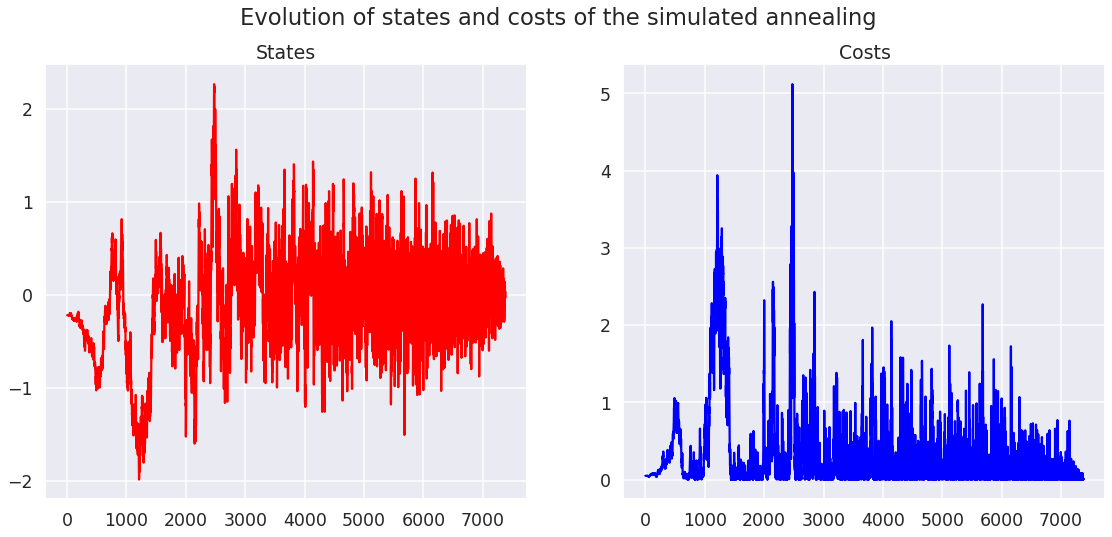

In [13]:
see_annealing(states, costs)

----

## More visualizations

In [14]:
def visualize_annealing(cost_function):
    state, c, states, costs = annealing(random_start, cost_function, random_neighbour, acceptance_probability, temperature, maxsteps=1000, debug=False)
    see_annealing(states, costs)
    return state, c

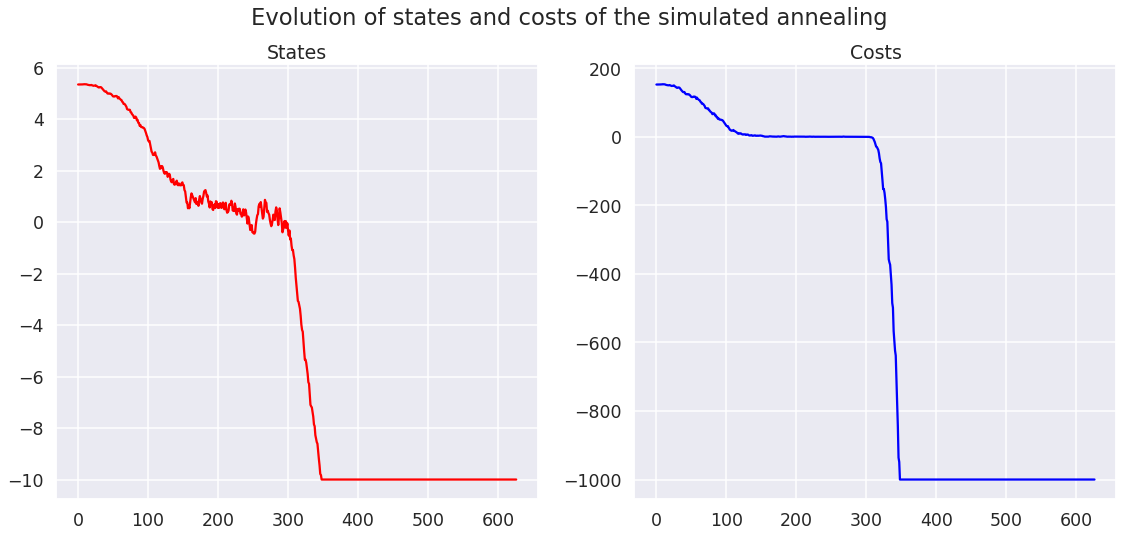

(-10, -1000)

In [15]:
visualize_annealing(lambda x: x**3)

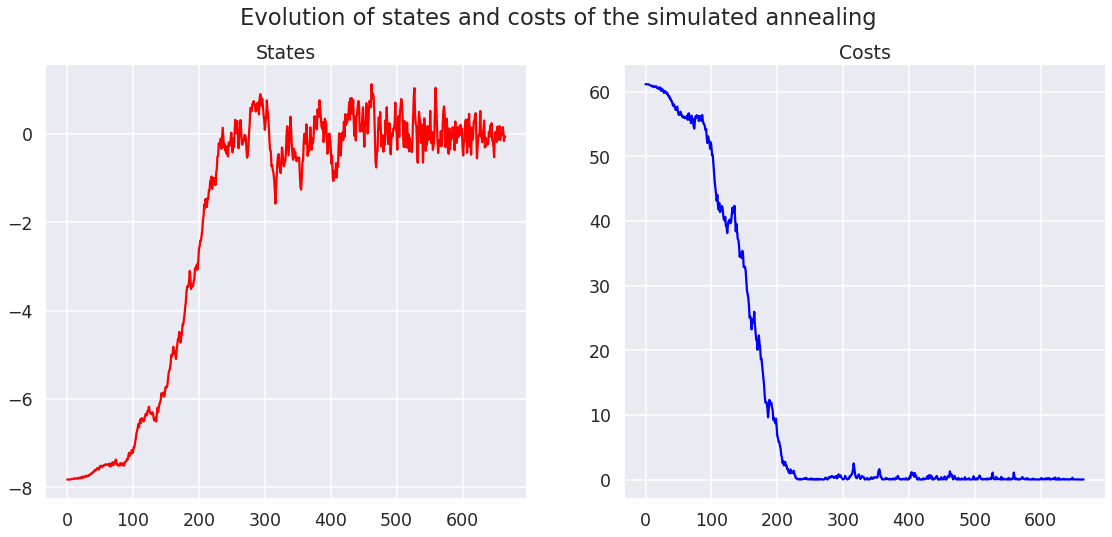

(-0.06386556938094146, 0.004078810952351847)

In [16]:
visualize_annealing(lambda x: x**2)

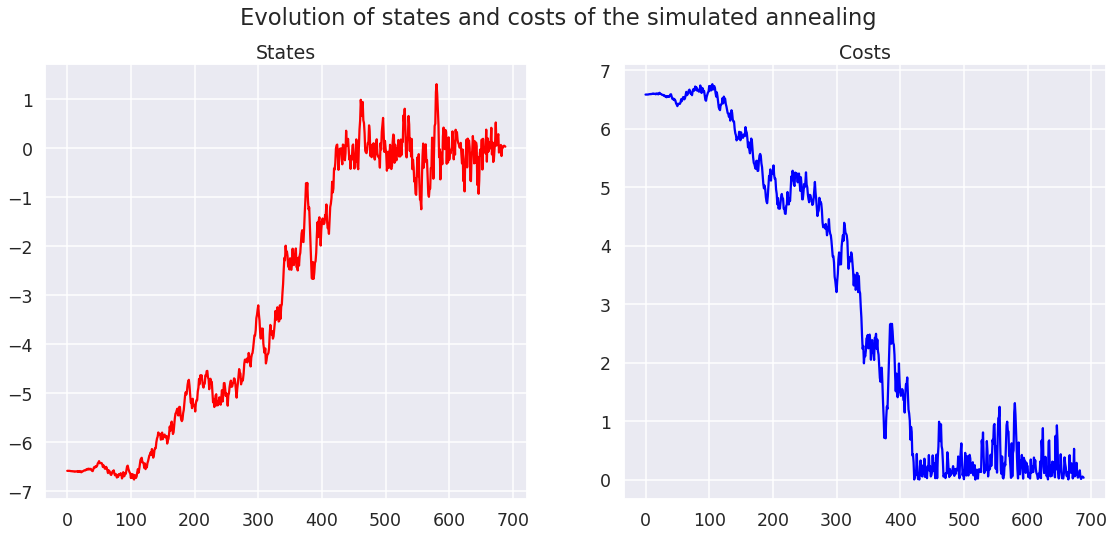

(0.03280649217294673, 0.03280649217294673)

In [17]:
visualize_annealing(np.abs)

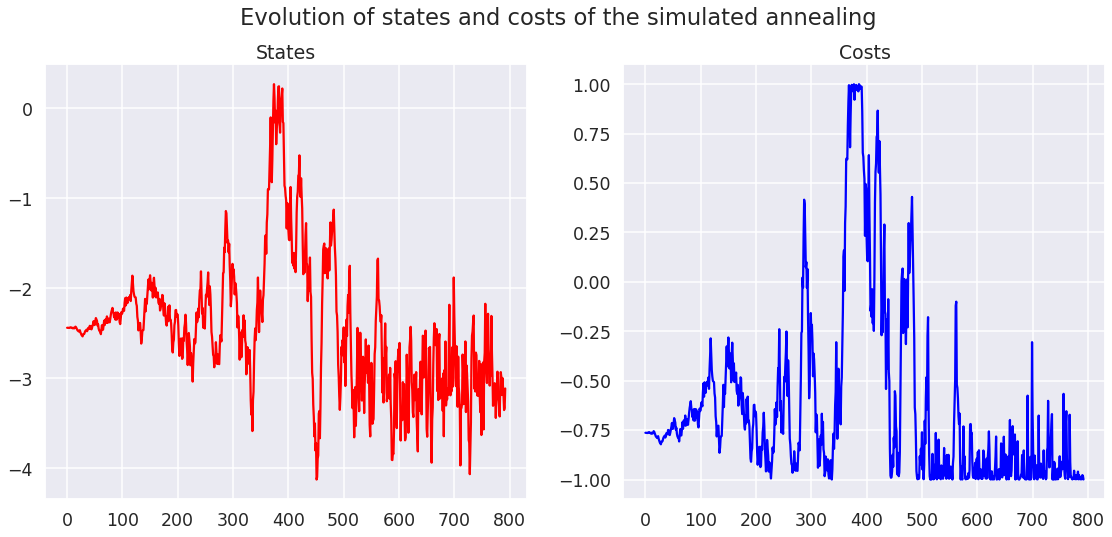

(-3.1144231861806255, -0.9996309327243613)

In [18]:
visualize_annealing(np.cos)

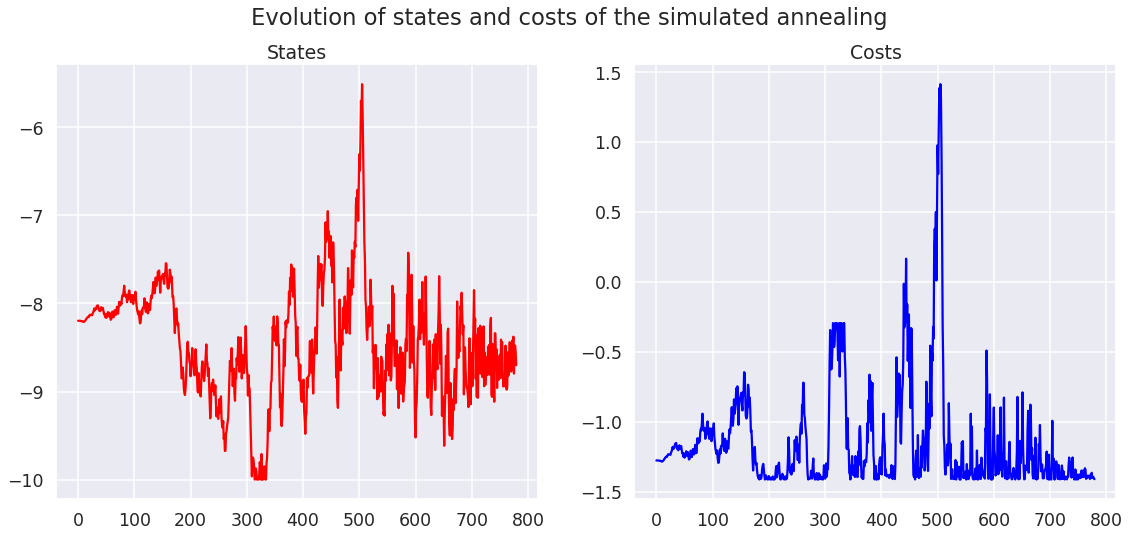

(-8.701169508899067, -1.4115147098330807)

In [19]:
visualize_annealing(lambda x: np.sin(x) + np.cos(x))

In all these examples, the simulated annealing converges to a global minimum.
It can be non-unique, but it is found.